# Life Expectancy Prediction using Multiple Linear Regression

Our goal in this challenge is to find the factors that affect the life expectancy. So, the target variable is `Life_Expectancy`. First we start with data cleaning by detecting and removing null-values and treating outliers. Then we move to Data Exploration and Feature Engineering. Do not forget that the target variable in our scenario is `Life_Expectancy`

The notebook includes the following sections:


1.   Data Cleaning
2.   Exploratory Data Analysis (EDA)
3.   Standardization of Features
4.   One-hot encoding
5.   Multiple Linear Regression Modeling
6.   K-Fold Cross Validation
7.   Goodness of Fit
8.   Regularization
9.   Conclusion


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
!pip install fancyimpute

     |████████████████████████████████| 154 kB 6.2 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=e0fd1fae429fc906877fdb6d4de5f71917d68405fe55eca7713fc03e9d66cc95
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=98b2d0f9d3f4721f5c01b29252d7d483d851339c7eb665941bfc83ab5f106642
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Life Expectancy Data (1).csv to Life Expectancy Data (1).csv


In [6]:
# Load the training data
import io
df = pd.read_csv(io.BytesIO(uploaded['Life Expectancy Data (1).csv']))

In [7]:
# Show the first 5 lines
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


# Data Cleaning

In [8]:
# Renaming some column names as they contain trailing spaces.
df.rename(columns={" BMI ":"BMI","Life expectancy ":"Life_Expectancy","Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths","percentage expenditure":"Percentage_Exp","Hepatitis B":"HepatitisB",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_1to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)

We can take a look at the descriptive statistics of the all the variables.

In [9]:
df.describe()

,Year,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


We can next move on to look at the data types for each feature and number of non null entries.

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   2938 non-null   object 
 1   Year                      2938 non-null   int64  
 2   Status                    2938 non-null   object 
 3   Life_Expectancy           2928 non-null   float64
 4   Adult_Mortality           2928 non-null   float64
 5   Infant_Deaths             2938 non-null   int64  
 6   Alcohol                   2744 non-null   float64
 7   Percentage_Exp            2938 non-null   float64
 8   HepatitisB                2385 non-null   float64
 9   Measles                   2938 non-null   int64  
 10  BMI                       2904 non-null   float64
 11  Under_Five_Deaths         2938 non-null   int64  
 12  Polio                     2919 non-null   float64
 13  Tot_Exp                   2712 non-null   float64
 14  Diphther

Does the dataframe contain any null values: True


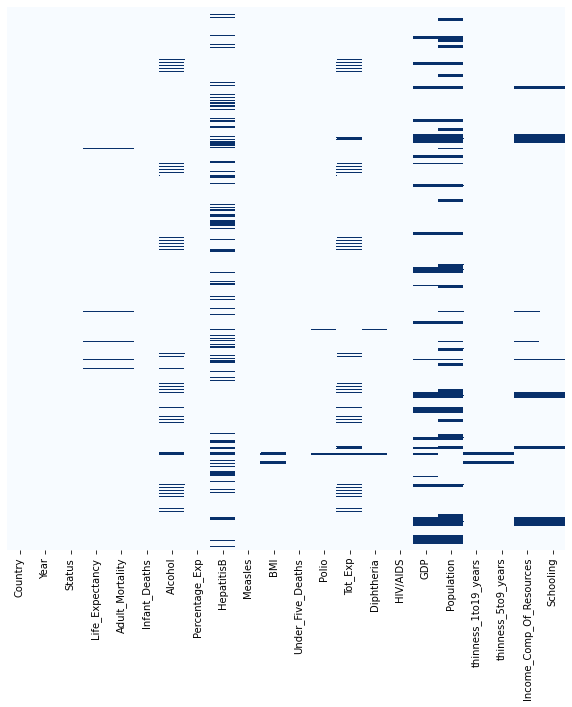

In [13]:
print(f'Does the dataframe contain any null values: {df.isnull().values.any()}') # check null values
#check if there are any Null values
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [14]:
import re
for col in df.columns:
    regex_pat = re.compile(r'^ *' + re.escape('NONE') + ' *$', flags=re.UNICODE | re.IGNORECASE)
    df.loc[:, col] = df[col].replace(regex_pat, np.nan, regex=True)

df.isnull().sum()

Country                       0
Year                          0
Status                        0
Life_Expectancy              10
Adult_Mortality              10
Infant_Deaths                 0
Alcohol                     194
Percentage_Exp                0
HepatitisB                  553
Measles                       0
BMI                          34
Under_Five_Deaths             0
Polio                        19
Tot_Exp                     226
Diphtheria                   19
HIV/AIDS                      0
GDP                         448
Population                  652
thinness_1to19_years         34
thinness_5to9_years          34
Income_Comp_Of_Resources    167
Schooling                   163
dtype: int64

In [15]:
index_names = df[np.isnan(df['Life_Expectancy'])].index
index_names
df.drop(index_names , inplace=True)

In [16]:
from fancyimpute import KNN    

# calling the KNN class
knn_imputer = KNN(5)
# imputing the missing value with knn imputer
df_lin = df.drop(['Status', 'Year', 'Country'], axis=1)
df_lin = pd.DataFrame(knn_imputer.fit_transform(df_lin),columns = df_lin.columns)

Imputing row 1/2928 with 0 missing, elapsed time: 1.962
Imputing row 101/2928 with 0 missing, elapsed time: 1.965
Imputing row 201/2928 with 0 missing, elapsed time: 1.968
Imputing row 301/2928 with 0 missing, elapsed time: 1.971
Imputing row 401/2928 with 2 missing, elapsed time: 1.977
Imputing row 501/2928 with 0 missing, elapsed time: 1.984
Imputing row 601/2928 with 0 missing, elapsed time: 1.986
Imputing row 701/2928 with 4 missing, elapsed time: 1.991
Imputing row 801/2928 with 4 missing, elapsed time: 1.998
Imputing row 901/2928 with 0 missing, elapsed time: 2.001
Imputing row 1001/2928 with 0 missing, elapsed time: 2.005
Imputing row 1101/2928 with 1 missing, elapsed time: 2.007
Imputing row 1201/2928 with 2 missing, elapsed time: 2.010
Imputing row 1301/2928 with 0 missing, elapsed time: 2.013
Imputing row 1401/2928 with 1 missing, elapsed time: 2.016
Imputing row 1501/2928 with 1 missing, elapsed time: 2.020
Imputing row 1601/2928 with 2 missing, elapsed time: 2.022
Imputing 

In [17]:
# Verifying null-values after applying above methods.
df_lin.isnull().sum()

Life_Expectancy             0
Adult_Mortality             0
Infant_Deaths               0
Alcohol                     0
Percentage_Exp              0
HepatitisB                  0
Measles                     0
BMI                         0
Under_Five_Deaths           0
Polio                       0
Tot_Exp                     0
Diphtheria                  0
HIV/AIDS                    0
GDP                         0
Population                  0
thinness_1to19_years        0
thinness_5to9_years         0
Income_Comp_Of_Resources    0
Schooling                   0
dtype: int64


# Exploratory Data Analysis (EDA)
We can plot a histogram of the dataframe for the features except "Status" to understand their distributions. <br/>

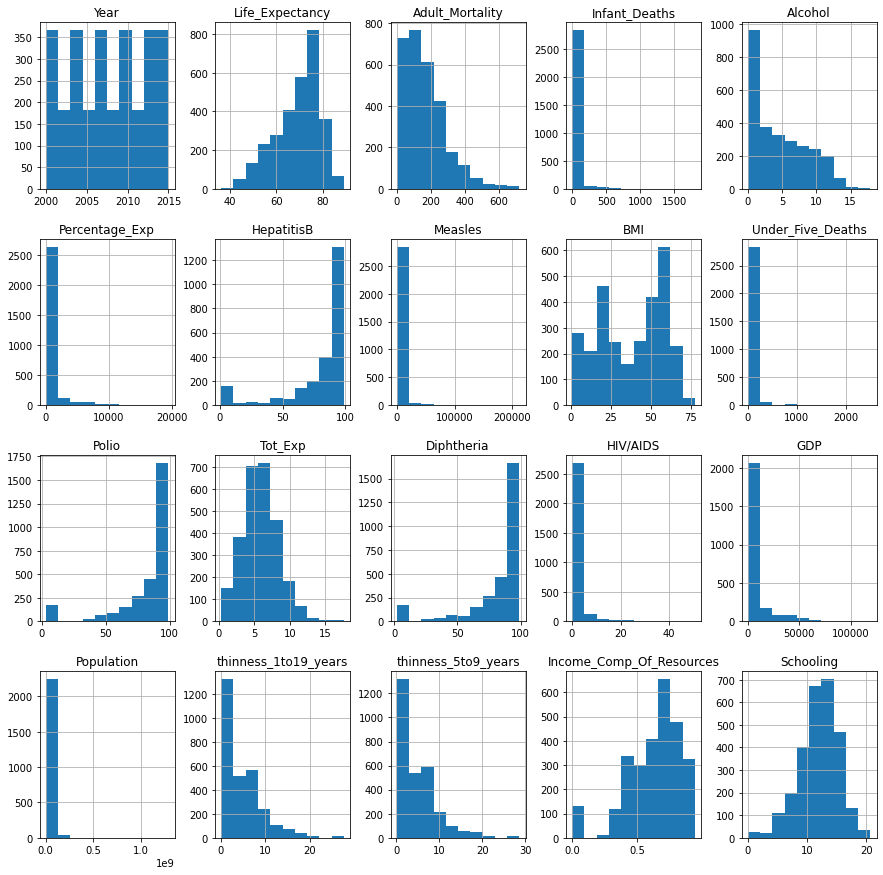

In [18]:
df.hist(figsize=(15,15), layout=(4,5))
plt.show()

Most of the variables are skewed and are in different scales.
- **Year**: It's a categorical variable. More values are present for later years than earlier years. Life Expectancy is consistently higher for developed countries compared to developing countries over all the years
- **Adult_mortality**: It's a tailed distribution, with values going to the right tails. Statistically, it has few outlier values (> 3 SD), but even for values +/-1 SD, the distribution is not perfectly normal. 
- **Alcohol**: The distribution is right-skewed, with values forming a long right tail. 
- **Percentage_expenditure**: The distribution is highly right-skewed. 80% of them lies on the left of mean with a lot of extreme values (upto 10x mean). log transformation should help here to get a more normally distributed like feature
- **BMI**: Looks like a multimodal distribution
- **Total_expenditure**: This can be a good candidate for a normal distribution. It's unimodal and looks like a normal distribution with thin tails on the both the ends
- **Diphtheria**: A lot of values are present towards the right side, so it's a left skewed histogram. Also immunization coverage is high for most of the rows
- **HIV_AIDS**: Generally have a low deaths per 1000 live births for most of the rows hence it's a right skewed distribution
- **GDP**: There are a few very high GDP data points which makes the histogram looks right skewed. Can get a better idea after removing those extreme values
- **Population**: It's a right skewed distribution. Most of the data points are on the relatively lower side of population
- **Income_compistion_of_resources**: Except for the isolated values in the left, this could be a good normally distributed feature. This can have a good differentiating power
- **Schooling**: This looks like a good normal distributed variable
- **Life_expectency**: Looks like the target variable is drawn from a normal distribution. Can try and use models which base their assumption of data being normally distributed.

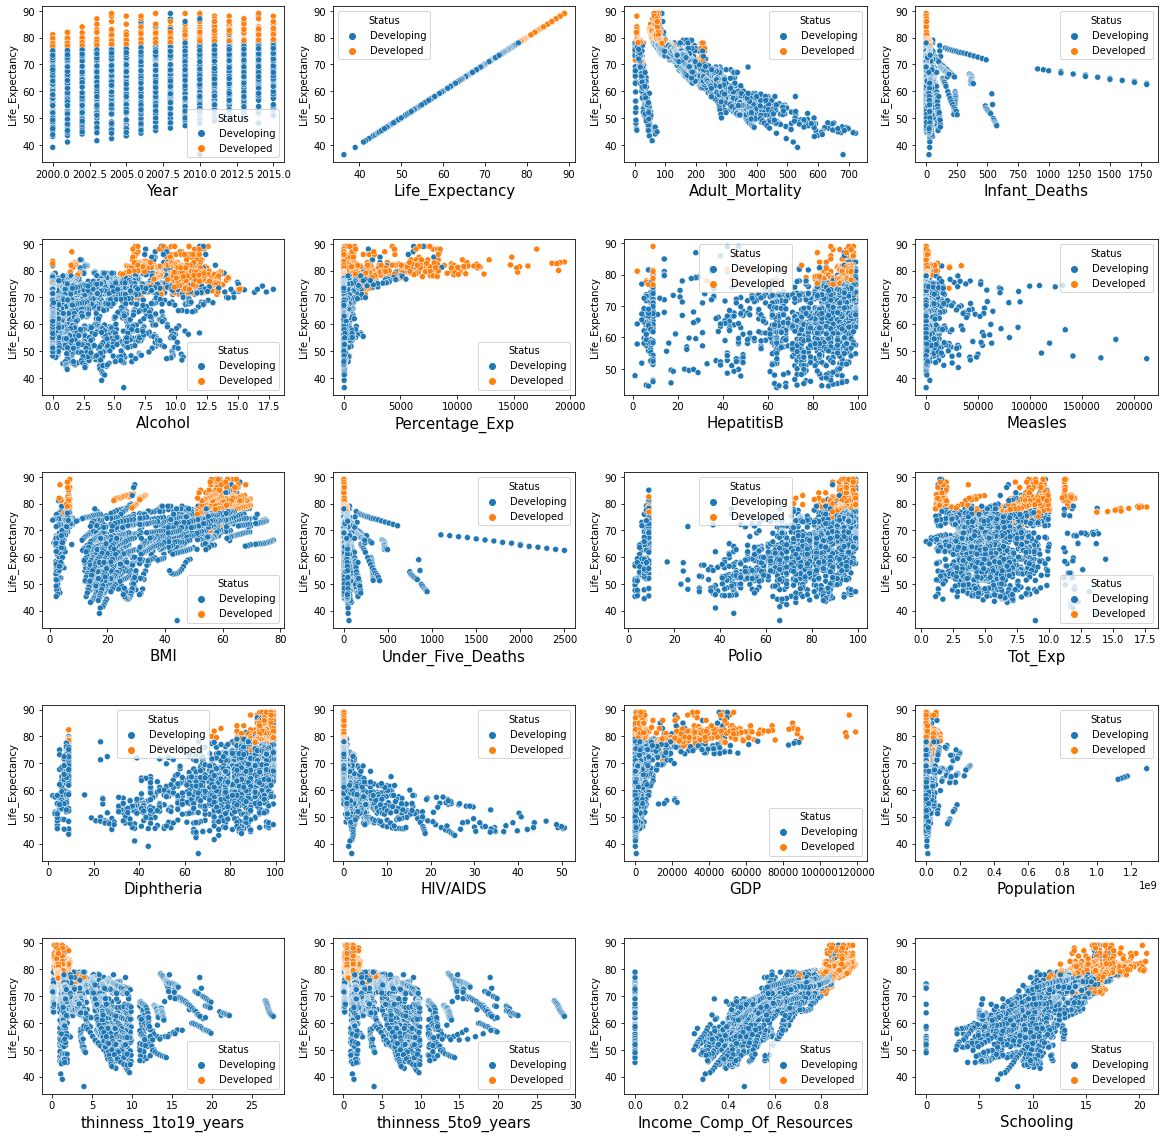

In [21]:
# Numerical featues against Life_Expetancy
fig, axs = plt.subplots(5,4, figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
cat_feature = [feature for feature in df.columns if df[feature].dtypes=='O']
num_feature = list(df.drop(cat_feature, axis=1).columns)

for c, feature in enumerate(num_feature):
    a = sns.scatterplot(x=feature, y='Life_Expectancy', data=df, ax = axs.flat[c], hue='Status')
    a.set_xlabel(feature,fontsize=15)

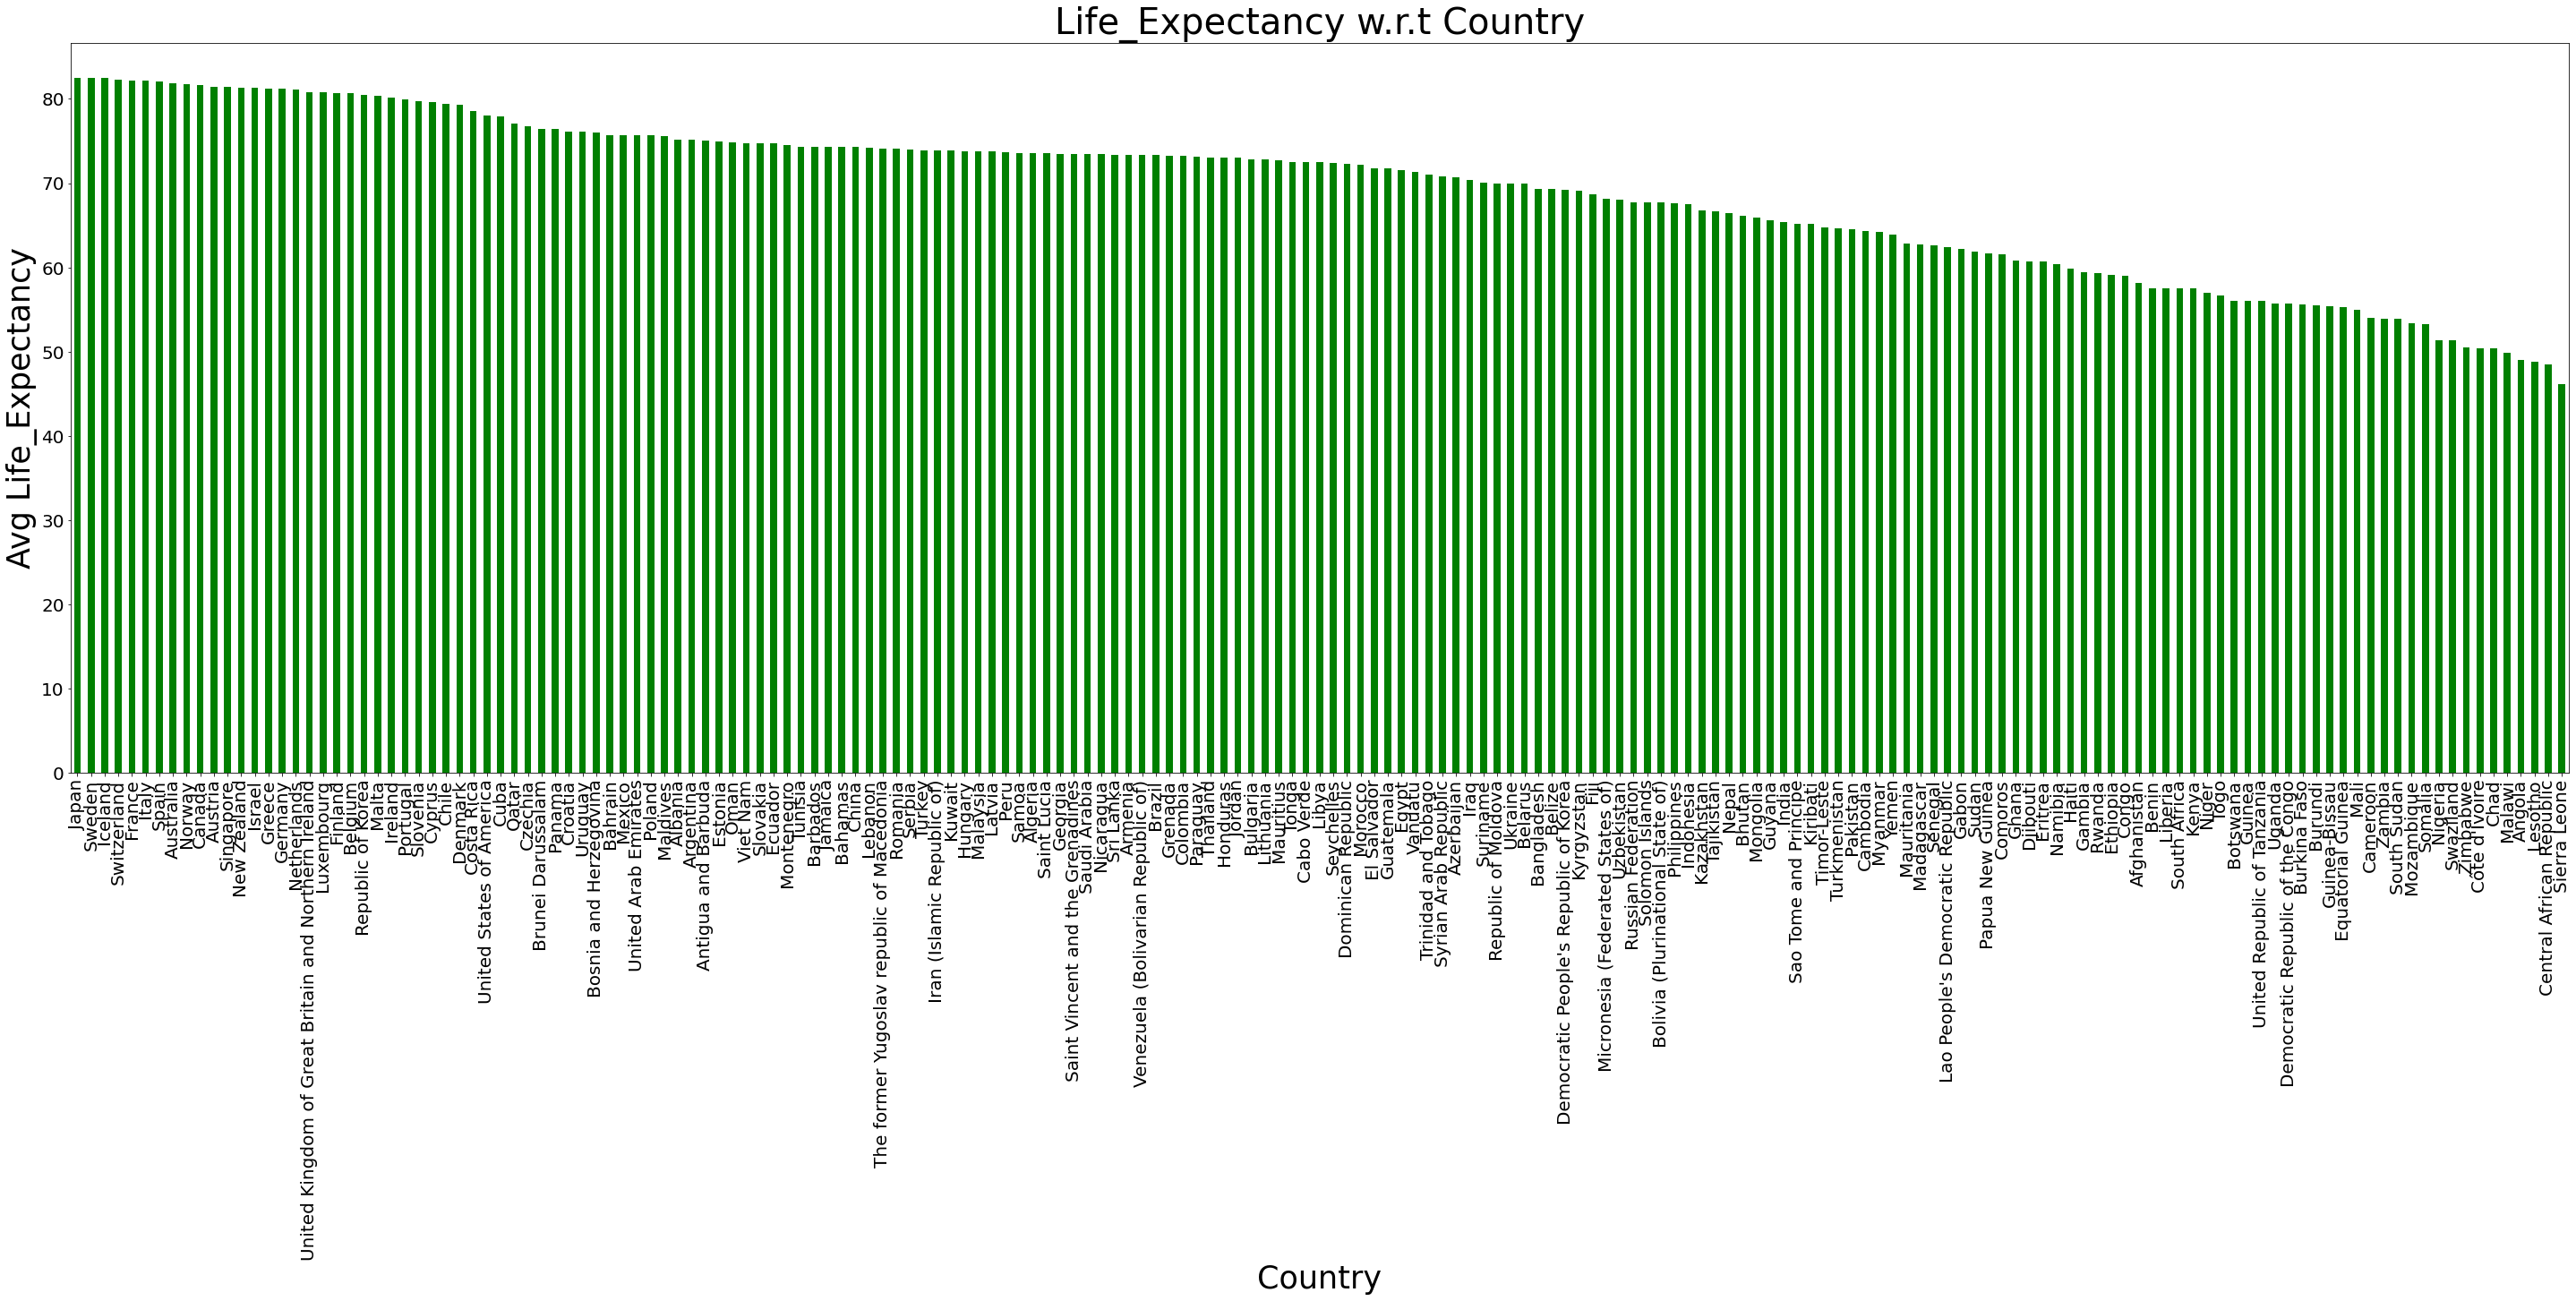

In [22]:
# Life_Expectancy w.r.t Country using bar plot.
le_country = df.groupby('Country')['Life_Expectancy'].mean()
le_country = le_country.sort_values(ascending=False)
le_country.plot(kind='bar', figsize=(50,15), fontsize=20, color='green')
plt.title("Life_Expectancy w.r.t Country",fontsize=40)
plt.xlabel("Country",fontsize=35)
plt.ylabel("Avg Life_Expectancy",fontsize=35)
plt.show()

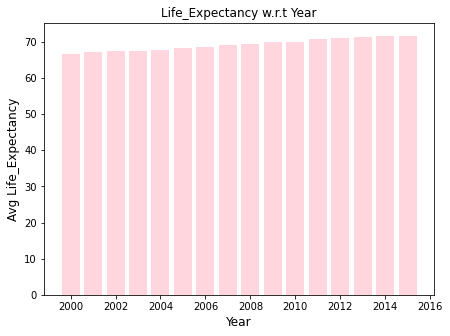

In [23]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(7,5))
plt.bar(df.groupby('Year')['Year'].count().index,df.groupby('Year')['Life_Expectancy'].mean(),color='pink',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Year")
plt.show()

Compute the correlation matrix to get an understanding of the correlation between life_expectancy and the other features.<br/>

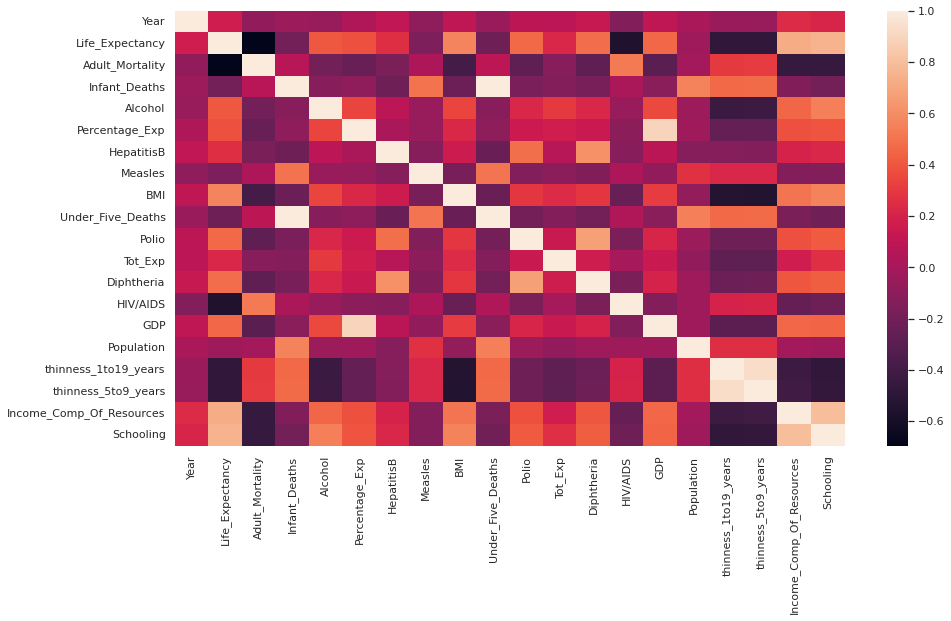

In [60]:
corr_data=df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_data)

# Standardization of features

Feature standardization makes the values of each feature in the data have zero-mean and unit-variance. This method is widely used for normalization in many machine learning algorithms. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values of each feature by its standard deviation.

$x'$ = ($x$ - $\bar{x}$)/$\sigma$ 

where $x$ is the original feature vector,
$\bar{x}$ is the mean of the feature vector and
$\sigma$ is its standard deviation.

This is also called Z-score Normalization. 

Perform Z-score Normalization on the features (except "Year" and "Status") in both training and test set. 

In [26]:
from sklearn.preprocessing import StandardScaler

# Perform Z-score Normalization on Training Data
df_normalized = df_lin.drop(['Life_Expectancy'], axis=1)  # dropping target column
scaler = StandardScaler().fit(df_normalized.values)
normalized_train = scaler.transform(df_normalized.values)
df_normalized = pd.DataFrame(normalized_train, columns=df_normalized.columns) 
df_normalized.head()

,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
0,0.790238,0.267520,-1.155623,-0.336102,-0.662783,-0.110924,-0.954241,0.254061,-3.266677,0.912997,-0.727904,-0.324055,-0.464260,0.367300,2.793799,2.755417,-0.700475,-0.558128
1,0.854614,0.284455,-1.155623,-0.334975,-0.788559,-0.168570,-0.979350,0.272732,-1.045511,0.921217,-0.854458,-0.324055,-0.462134,-0.202245,2.861833,2.799895,-0.714837,-0.588243
2,0.830473,0.301391,-1.155623,-0.335128,-0.704708,-0.173968,-1.004460,0.291403,-0.874652,0.900665,-0.770088,-0.324055,-0.460710,0.333123,2.907190,2.844373,-0.743561,-0.618357
3,0.862660,0.326794,-1.155623,-0.332633,-0.578933,0.031273,-1.029570,0.316299,-0.661079,1.060970,-0.643534,-0.324055,-0.457853,-0.144805,2.952546,2.911089,-0.777071,-0.648472
4,0.886801,0.343730,-1.155623,-0.368345,-0.537007,0.050953,-1.049657,0.341194,-0.618364,0.793795,-0.601349,-0.324055,-0.503187,-0.157051,3.020580,2.955567,-0.820156,-0.738817


**What are the advantages and disadvantages of using Z-score Normalization?**

Ans-  Advantages:
1. Better interpretation of variables: Enable us to compare values of different features by bringing them on same scale.
2. Improves computation speed.

Disadvantages:
1. Hard to interpret the meaning of values for individual varialbles after normalization.
2. Only applicable for interval data.
3. Assume that the data is reasonably normally distributed.

In this dataset, do you need to use the Z-score Normalization? Explain.<br/>
Ans- We need to use Z-score Normalization for this dataset because we want each feature to be equally important when building model. Since it is a linear model, the variables with higher scale might get penalized more.

# One-Hot Encoding

"Year" and "Status" can only take discrete values. We need to perform one-hot encoding on discrete values for it to be processed in the model. One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.
Perform one-hot encoding on "Year" and "Status" and print the shape of your encoded array

In [27]:
from sklearn.preprocessing import OneHotEncoder
### WRITE CODE TO PERFORM ONE-HOT CODING ON "Year" AND "Status" ###
enc = OneHotEncoder(handle_unknown='ignore', drop='first')
enc = enc.fit(df[['Status','Country']])

# Transform 'Status' and 'Year' into discrete values using one-hot encoding on training data.
enc_train = pd.DataFrame(enc.transform(df[['Status','Country']]).toarray(), columns = enc.get_feature_names_out(['Status', 'Country']))
df_normalized = df_normalized.join(enc_train) 

df_normalized.head()

,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling,Status_Developing,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,Country_Bahrain,Country_Bangladesh,Country_Barbados,Country_Belarus,Country_Belgium,Country_Belize,Country_Benin,Country_Bhutan,Country_Bolivia (Plurinational State of),Country_Bosnia and Herzegovina,Country_Botswana,...,Country_Sierra Leone,Country_Singapore,Country_Slovakia,Country_Slovenia,Country_Solomon Islands,Country_Somalia,Country_South Africa,Country_South Sudan,Country_Spain,Country_Sri Lanka,Country_Sudan,Country_Suriname,Country_Swaziland,Country_Sweden,Country_Switzerland,Country_Syrian Arab Republic,Country_Tajikistan,Country_Thailand,Country_The former Yugoslav republic of Macedonia,Country_Timor-Leste,Country_Togo,Country_Tonga,Country_Trinidad and Tobago,Country_Tunisia,Country_Turkey,Country_Turkmenistan,Country_Uganda,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom of Great Britain and Northern Ireland,Country_United Republic of Tanzania,Country_United States of America,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe
0,0.790238,0.267520,-1.155623,-0.336102,-0.662783,-0.110924,-0.954241,0.254061,-3.266677,0.912997,-0.727904,-0.324055,-0.464260,0.367300,2.793799,2.755417,-0.700475,-0.558128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.854614,0.284455,-1.155623,-0.334975,-0.788559,-0.168570,-0.979350,0.272732,-1.045511,0.921217,-0.854458,-0.324055,-0.462134,-0.202245,2.861833,2.799895,-0.714837,-0.588243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.830473,0.301391,-1.155623,-0.335128,-0.704708,-0.173968,-1.004460,0.291403,-0.874652,0.900665,-0.770088,-0.324055,-0.460710,0.333123,2.907190,2.844373,-0.743561,-0.618357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.862660,0.326794,-1.155623,-0.332633,-0.578933,0.031273,-1.029570,0.316299,-0.661079,1.060970,-0.643534,-0.324055,-0.457853,-0.144805,2.952546,2.911089,-0.777071,-0.648472,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.886801,0.343730,-1.155623,-0.368345,-0.537007,0.050953,-1.049657,0.341194,-0.618364,0.793795,-0.601349,-0.324055,-0.503187,-0.157051,3.020580,2.955567,-0.820156,-0.738817,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Print the shape of your encoded X
X = df_normalized.copy()
print(f'Shape of encoded X in the training dataset: {X.shape}')
y = df['Life_Expectancy']
print(f'Shape of encoded y in the training dataset: {y.shape}')

Shape of encoded X in the training dataset: (2928, 201)
Shape of encoded y in the training dataset: (2928,)


**What are the advantages and disadvantages of using One-hot encoding?**

Ans- Advantages: 
1. Using this technique, we can give qualitative inputs to machine learning models to learn from by transforming them to quantitative values
2. Useful in cases where categorical data is unordered. Thus, this can prevent machine learning models from treating the order of numbers as an attribute of significance

Disadvantages:
1. Cannot capture difference in the categories for a particular feature between training and test data.
2. Can lead to a large number of features & sparse dataset for the training of the model

# Multiple Linear Regression Modeling

In the big data era, it is highly unlikely that we are interested in the effect of a single variable on another. To simultaneously account for the effects of multiple variables, we use multiple regression (which accounts for the covariances between predictors).

While the algorithmic solution to multiple regression exists, it is easier to conceptualize in terms of linear algebra. The optimal $\hat{\beta}$ vector that minimizes the residual sum of squares is:

$\hat{\beta} = (X^TX)^{-1}X^Ty $


Perform multiple linear regression on the training dataset, where the outcome is "Life_expectancy".

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
from sklearn.model_selection import train_test_split
# Lets set 30% for testing and 70% for training the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [31]:
### Bulding and fitting the Multiple Linear Regression model###
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
y_prediction =  mlr_model.predict(X_test)

In [32]:
### Evaluate the Linear Regression model by computing MSE on the training set###
from sklearn.metrics import mean_squared_error
score = mean_squared_error(y_test,y_prediction)
print(f'Mean Squared Error is: {score}')

Mean Squared Error is: 5.275477910897511


In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_prediction)
r2

0.9387168173322535

# K-fold Cross-Validation

However, adjusted $R^2$ is not enough to help us achieve the best model, a more robust method is k-fold cross-validation.

* Randomly split dataset into K equal-sized subsets, or folds
* Treat each fold as validation set (train on all but K'th fold and test on K'th fold only)

* The overall error is then the mean error over all K models.
* Most common are 5- or 10-fold cross-validation


In [67]:
def cross_val_mse(X, y, f=5):
    ### Write your code here ###
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    mse_list = []
    for test_index in np.array_split(indices, f):
      train_index = list(set(indices) - set(test_index))
      X_train = X.iloc[train_index]
      X_test = X.iloc[test_index]
      y_train = y.iloc[train_index]
      y_test = y.iloc[test_index]

      model = LinearRegression()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse_list.append(mean_squared_error(y_test, y_pred))
    return np.array(mse_list).mean()

In [68]:
mse = cross_val_mse(X, y, f=5)
print(mse)

4.9982297799484625


# Goodness of fit

A model can always make predictions. But it is important to determine how good the model is.
How do we know that our model captures the data well? When evaluating model fit, a good metric is $R^2$, which corresponds to the amount of variance explained by the model. The formula for $R^2$ is the following:

$R^2$ = $1 - \dfrac{RSS}{TSS}$<br/>
where:<br/>
$RSS = \Sigma(y - \hat{y})^2$<br/>
$TSS = \Sigma(y - \bar{y})^2$<br/>

$R^2$ is also one metric for comparing models against each other. It is intuitive to say that the model that explains more variation in the data is a better fit than one that explains less variation. 

$R^2$ for model with "Schooling" as predictor and "Life_expectancy" as outcome

In [69]:
model1 = LinearRegression()
X1 = X_train[['Schooling']]
X1_test = X_test[['Schooling']]
y1 = y_train.copy()
model1.fit(X1, y1)

# Print R2 score
r2_1 = r2_score(y_test, model1.predict(X1_test))
print(f'R2 score for model with "Schooling" as predictor and "Life_expectancy" as outcome is {r2_1}')

R2 score for model with "Schooling" as predictor and "Life_expectancy" as outcome is 0.5542156516811636


$R^2$ for model with "Schooling", "Adult_Mortality" as predictor and "Life_expectancy" as outcome

In [70]:
### WRITE CODE ###
model2 = LinearRegression()
X2 = X_train[['Schooling', 'Adult_Mortality']]
X2_test = X_test[['Schooling', 'Adult_Mortality']]
y2 = y_train.copy()
model2.fit(X2, y2)

# Print R2 score
r2_2 = r2_score(y_test, model2.predict(X2_test))
print(f'R2 score for model with "Schooling", "Adult_Mortality" as predictors and "Life_expectancy" as outcome is {r2_2}')

R2 score for model with "Schooling", "Adult_Mortality" as predictors and "Life_expectancy" as outcome is 0.7147431709853416


$R^2$ for model with "Schooling", "Adult_Mortality" and "Population" as predictor and "Life_expectancy" as outcome

In [71]:
### WRITE CODE ###
model3 = LinearRegression()
X3 = X_train[['Schooling', 'Adult_Mortality', 'Population']]
X3_test = X_test[['Schooling', 'Adult_Mortality', 'Population']]
y3 = y_train.copy()
model3.fit(X3, y3)

# Print R2 score
r2_3 = r2_score(y_test, model3.predict(X3_test))
print(f'R2 score for model with "Schooling", "Adult_Mortality" and "Population" as predictors and "Life_expectancy" as outcome is {r2_3}')

R2 score for model with "Schooling", "Adult_Mortality" and "Population" as predictors and "Life_expectancy" as outcome is 0.7153109167913609


You can see $R^2$ is always going up as we keep adding features.

This is one drawback of only using $R^2$ to evaluate your model. Adding predictors seems to always improve the predictive ability of your model, though it may not be true.

That is to say, we are not necessarily interested in making a perfect prediction of our training data. If we were, we would always use all of the predictors available. Rather, we would like to make a perfect prediction of our test data. In this case, adding all the predictors may not be a good idea due to the trade-off between bias and variance. Thus, we are interested in the most predictive features, in the hopes that we can create a simpler model that performs well in the future.

This is why we consider another metric, Adjusted R2.
The adjusted R-squared increases only if the new term improves the model more than would be expected by chance.


$AdjustedR^2$ = $1 - \dfrac{(1-R^2)(n-1)}{(n-k-1)}$<br/>
where:<br/>
n = number of samples<br/>
k = number of features

Fill in the code for calculation of adjusted R2 score

Adjusted $R^2$ for model with "Schooling" as predictor and "Life_expectancy" as outcome

In [72]:
### WRITE CODE ###
n = len(X_train) # number of samples
k = 1 # number of features

# Print Adjusted R2 score
adj_r2_1 = 1-(1-r2_1)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with "Schooling" as predictor and "Life_expectancy" as outcome is {adj_r2_1}')

Adjusted R2 score for model with "Schooling" as predictor and "Life_expectancy" as outcome is 0.5539978772071437


Adjusted $R^2$ for model with "Schooling", "Adult_Mortality" as predictor and "Life_expectancy" as outcome.

In [73]:
### WRITE CODE ###
k = 2 # number of features

# Print Adjusted R2 score
adj_r2_2 = 1-(1-r2_2)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with "Schooling", "Adult_Mortality" as predictors and "Life_expectancy" as outcome is {adj_r2_2}')

Adjusted R2 score for model with "Schooling", "Adult_Mortality" as predictors and "Life_expectancy" as outcome is 0.7144643275552197


Adjusted $R^2$ for model with "Schooling","Adult_Mortality" and "Population" as predictor and "Life_expectancy" as outcome

In [74]:
### WRITE CODE ###
k = 3 # number of features

# Print Adjusted R2 score
adj_r2_3 = 1-(1-r2_3)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with "Schooling", "Adult_Mortality" and "Population" as predictors and "Life_expectancy" as outcome is {adj_r2_3}')

Adjusted R2 score for model with "Schooling", "Adult_Mortality" and "Population" as predictors and "Life_expectancy" as outcome is 0.7148932799944778


In [77]:
k = 201
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is {adj_r2}')

Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is 0.9320476675129699


# Regularization

Often we want conduct a process called regularization, wherein we penalize the number of features in a model in order to only keep the most important features. This can be particularly important when you have a dataset with a large number of features.


In [40]:
from sklearn.linear_model import Ridge

In [41]:
ridge_model=Ridge()
ridge_model.fit(X_train,y_train)

Ridge()

In [42]:
y_predictions_rd=ridge_model.predict(X_test)

In [43]:
score = mean_squared_error(y_test, y_predictions_rd)
print(f'Mean Squared Error is: {score}')

Mean Squared Error is: 5.612496410678106


In [80]:
r2_ridge = r2_score(y_test, y_predictions_rd)
k = 201
adj_r2_ridge = 1-(1-r2_ridge)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is {adj_r2_ridge}')

Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is 0.9277066023927719


In [81]:
from sklearn.linear_model import Lasso

In [82]:
lasso_model=Lasso(alpha=0.00005)
lasso_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.984e+03, tolerance: 1.895e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=5e-05)

In [83]:
y_predictions_ls = lasso_model.predict(X_test)

In [84]:
score = mean_squared_error(y_test, y_predictions_ls)
print(f'Mean Squared Error is: {score}')

Mean Squared Error is: 5.206625162546232


In [85]:
r2_lasso = r2_score(y_test, y_predictions_ls)
k = 201
adj_r2_lasso = 1-(1-r2_lasso)*(n-1)/(n-k-1)
print(f'Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is {adj_r2_lasso}')

Adjusted R2 score for model with all features as predictors and "Life_expectancy" as outcome is 0.9329345454276602


**When to choose Linear Regression over Lasso or Ridge?**

Even though we had good score by using Lasso we choose Linear regression over it.
As we choose more generalised method the flexibility in model decreases which indirectly results in the interpretability of the model.
Interpretability in the model is much useful when we are solving problems, where our main goal would be knowing the relations in between the features.
But Lasso is also very powerful when we have alot of attributes in our data when p>n.



# Conclusion

We first Data Cleaning and imputation to address the missing calues in our data. We then followed this with EDA and transformation of features such as Normalization and One-hot encoding.

We used the Linear Regression Model and measured its performance using `Adjusted R-squared` and `MSE`. We then compared it with Lasso and Ridge Regularizations to finally choose the best model.

We achieved an `Adjusted R-squared` of 93.02% in the best-fit model and an `MSE` of `4.983`

